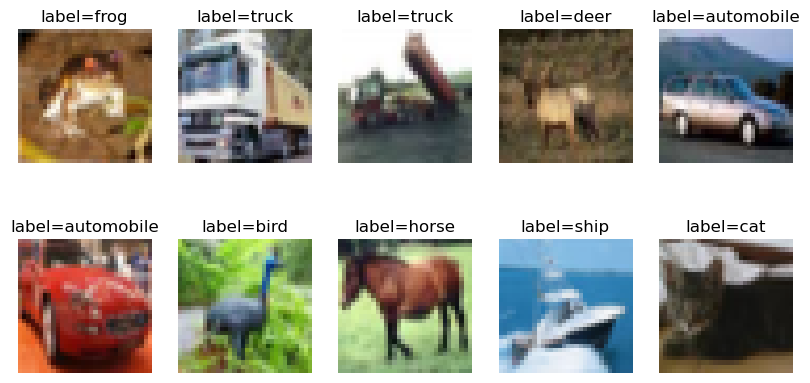

In [70]:
"""Download the CIFAR10 dataset using tensorflow.keras.datasets.cifar10.load_data(). 
This dataset contains 60k (50k training / 10k test) low resolution color images for 10 classes: 
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'].

Verify data by plotting image samples.

"""


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


def plot_image(ax, img ,label , class_names=class_names):
    ax.imshow(img)
    ax.set_title(f"label={class_names[label]}")
    ax.axis('off')

#plot some sample images
rows, cols=(2,5)
fig, ax= plt.subplots(rows,cols, figsize=(10,5))
k=0
for i in range(rows):
    for j in range(cols):
        plot_image(ax[i][j], train_images[k], train_labels[k][0])
        k+=1

plt.show()


In [109]:
"""Allocate a sequential model containing a normalization layer after determining the best choice for this particular dataset.
After this initial normalization layer, threat images as a flatten layer, and build a classifier. 
Train the classifier using the test data as validation set. 
Store and plot the accuracy for the training and validation achieved with this approach.

Redesign the previous model by replacing the initial flatten layer with convolutional layers (tf.keras.layers.Conv2D)
followed by a Max Pooling 2D layer (tf.keras.layers.MaxPooling2D). Try this model with 3 consecutive layers. 
Compare the results with the previous model."""

def subplots(ax, x, y, label, title, xlabel="epochs"):
    ax.plot(x,y, color='goldenrod', label=label)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    
def build_model():

    model=tf.keras.models.Sequential([tf.keras.layers.Rescaling(1./255.0, input_shape=(32,32,3)), #norm. layer, rescales pixel values to [0,1]
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(10, activation='softmax')])#output
    return model

def build_cnn():

    model=tf.keras.models.Sequential([tf.keras.layers.Rescaling(1./255.0, input_shape=(224, 224, 3)),#rgb
                                      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),#first layer capture local feature, less filters needed 
                                      tf.keras.layers.MaxPooling2D(),
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),#deeper features, more filters
                                      tf.keras.layers.MaxPooling2D(),
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                      tf.keras.layers.MaxPooling2D(),
                                      tf.keras.layers.Flatten(), #flattening layers and classification
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(4, activation='softmax')])#output
    return model
                                      







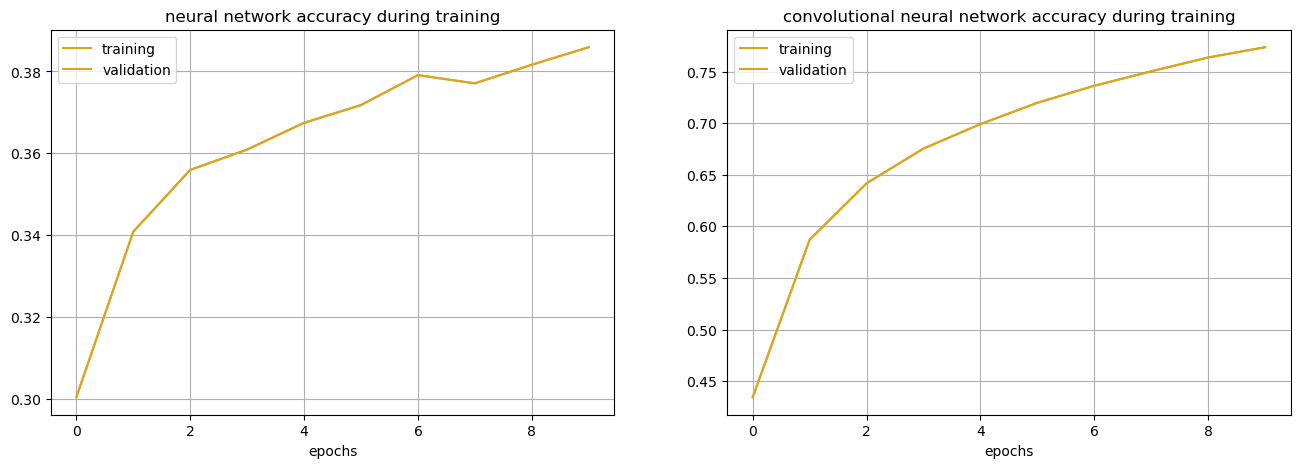

In [111]:
nn=build_model()
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#train model
epochs=10
history=nn.fit(train_images, train_labels, epochs=epochs, batch_size=32, validation_data=(test_images, test_labels), verbose=0)
#store and plot metrics
accTrain=history.history['accuracy']
accVal=history.history['val_accuracy']
CNN=build_cnn()
#train CNN the same way
CNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
historycnn=CNN.fit(train_images, train_labels, epochs=epochs, batch_size=32, validation_data=(test_images, test_labels), verbose=0)
accTraincnn=historycnn.history['accuracy']
accValcnn=historycnn.history['val_accuracy']
#plot
fig, ax=plt.subplots(1,2, figsize=(16,5))
N=np.arange(epochs)
subplots(ax[0], N, accTrain,"training", "neural network accuracy during training")
subplots(ax[0], N, accTrain, "validation", "neural network accuracy during training")
subplots(ax[1], N, accTraincnn,"training", "convolutional neural network accuracy during training")
subplots(ax[1], N, accTraincnn, "validation", "convolutional neural network accuracy during training")
plt.show()

# Exercise 2: Localization and classification

1. We provide images of 75x75 pixels containing MNIST digits in the data.tgz folder above. Each image contains only one digit of 28x28 pixels placed in a random position of the image. The files training_images.npy and validation_images.npy contains the images, training_labels.npy and validation_labels.npy the labels of each image, training_boxes.npy and validation_boxes.npy the 4 coordinates of the bounding boxes (xmin, ymin, xmax, ymax). Load data and plot samples.

2. Construct a custom Keras model (using the functional API) with the following components:

   - a feature extractor using a CNN followed by a flatten and a dense layer and two final end-points: a classifier (10 classes) and a        bounding box regressor (4 coordinates).
   - Use the categorical cross-entropy loss function for the classifier and the MSE for the bounding box regressor.


3. Plot the classification and bounding box losses. Verify the results on the validation dataset by plotting samples and computing the IoU. Evaluate the total number of good and bad bounding box predictions using an IoU threshold of 0.6.

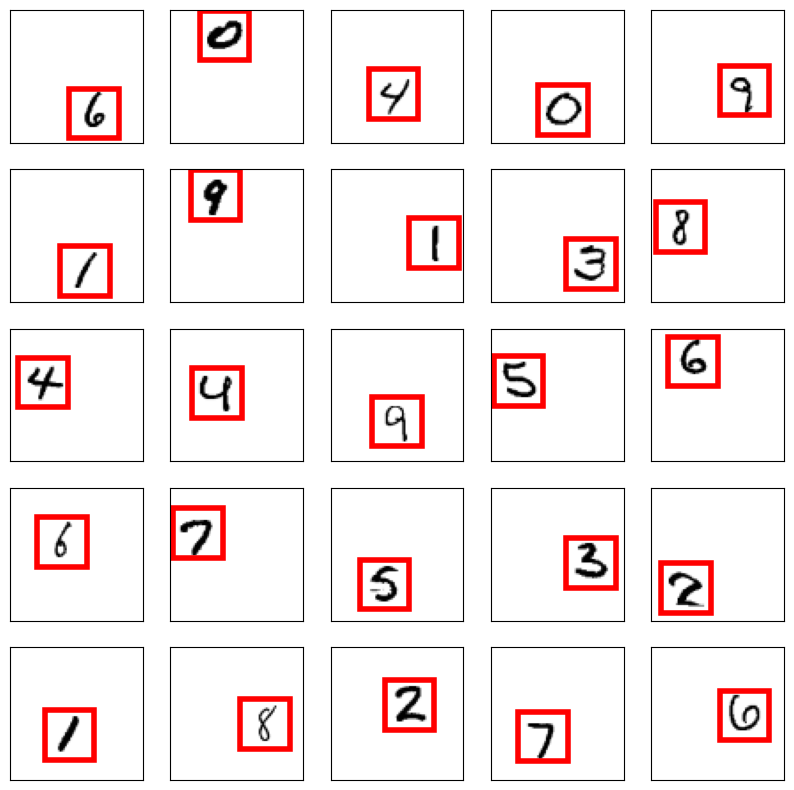

In [136]:
#1
from matplotlib.patches import Rectangle

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(history.history['classifier_loss'], label='classifier loss')
    ax1.plot(history.history['val_classifier_loss'], label='val classifier loss')
    ax2.plot(history.history['regressor_loss'], label='bounding box loss')
    ax2.plot(history.history['val_regressor_loss'], label='val bounding box loss')
    ax1.legend(frameon=False)
    ax2.legend(frameon=False)
    plt.show()


def plot_sample(images, boxes, pboxes=None, plot_predictions=False):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='binary')
        center = (boxes[i, 0]*75, boxes[i, 1]*75)
        plt.gca().add_patch(Rectangle(center,
                                      (boxes[i, 2]-boxes[i, 0])*75,
                                      (boxes[i, 3]-boxes[i, 1])*75,
                                      edgecolor='red',
                                      facecolor='none',
                                      lw=4))
        if plot_predictions:
            center = (pboxes[i, 0]*75, pboxes[i, 1]*75)
            plt.gca().add_patch(Rectangle(center,
                                        (pboxes[i, 2]-pboxes[i, 0])*75,
                                        (pboxes[i, 3]-pboxes[i, 1])*75,
                                        edgecolor='blue',
                                        facecolor='none',
                                        lw=4))
    plt.show()

training_images = np.load('data/training_images.npy')
training_boxes = np.load('data/training_boxes.npy')
training_labels = np.load('data/training_labels.npy')

validation_images = np.load('data/validation_images.npy')
validation_boxes = np.load('data/validation_boxes.npy')
validation_labels = np.load('data/validation_labels.npy')
plot_sample(training_images, training_boxes)

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 73, 73,    │        320 │ input_layer_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 36, 36,    │          0 │ conv2d_27[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 34, 34,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 17, 17,    │          0 │ conv2d_28[0][0]   │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 15, 15,    │     36,928 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 7, 7, 64)  │          0 │ conv2d_29[0][0]   │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 3136)      │          0 │ average_pooling2… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │    401,536 │ flatten_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 10)        │      1,290 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor (Dense)   │ (None, 4)         │        516 │ dense_32[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 459,086 (1.75 MB)

 Trainable params: 459,086 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 71s 38ms/step - classifier_acc: 0.5717 - classifier_loss: 1.1808 - loss: 1.2002 - regressor_loss: 0.0194 - regressor_mse: 0.0194 - val_classifier_acc: 0.9461 - val_classifier_loss: 0.1714 - val_loss: 0.1773 - val_regressor_loss: 0.0056 - val_regressor_mse: 0.0056
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 71s 38ms/step - classifier_acc: 0.9480 - classifier_loss: 0.1684 - loss: 0.1728 - regressor_loss: 0.0044 - regressor_mse: 0.0044 - val_classifier_acc: 0.9655 - val_classifier_loss: 0.1058 - val_loss: 0.1092 - val_regressor_loss: 0.0033 - val_regressor_mse: 0.0033
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - classifier_acc: 0.9695 - classifier_loss: 0.0950 - loss: 0.0977 - regressor_loss: 0.0027 - regressor_mse: 0.0027 - val_classifier_acc: 0.9714 - val_classifier_loss: 0.0915 - val_loss: 0.0943 - val_regressor_loss: 0.0027 - val_regressor_mse: 0.0027
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - classifier_acc: 0.9802 -

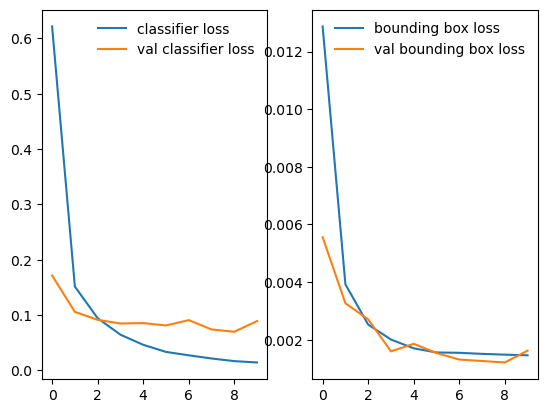

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


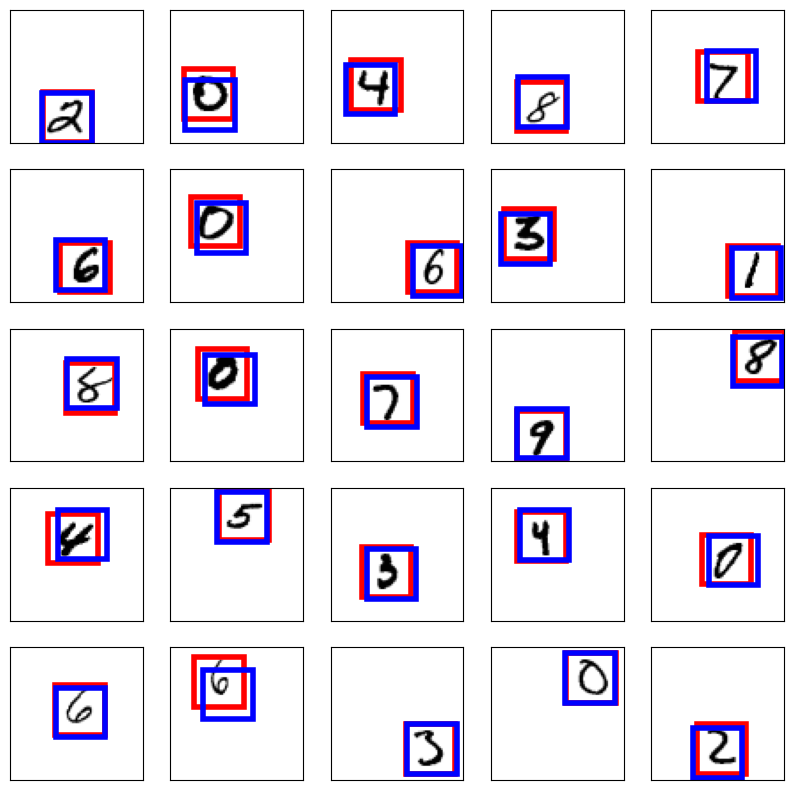

In [137]:
#build CNN for regression+classification with the functional API

inputs=tf.keras.layers.Input(shape=(75,75,1))#input layer
conv1=tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)#convolutional layers
pool1=tf.keras.layers.AveragePooling2D((2,2))(conv1)
conv2=tf.keras.layers.Conv2D(64, (3,3), activation='relu')(pool1)
pool2=tf.keras.layers.AveragePooling2D((2,2))(conv2)
conv3=tf.keras.layers.Conv2D(64, (3,3), activation='relu')(pool2)
pool3=tf.keras.layers.AveragePooling2D((2,2))(conv3)
#flattening layer
flattening=tf.keras.layers.Flatten()(pool3)
feature=tf.keras.layers.Dense(128, activation='relu')(flattening)
#now setup the double ouptut: 10 node-softmax classifier and 4 nodes linear regressor, give them names to compile later
classification=tf.keras.layers.Dense(10, activation='softmax', name='classifier')(feature)
regression=tf.keras.layers.Dense(4, activation='linear', name='regressor')(feature)
#build model
model=tf.keras.Model(inputs=inputs, outputs=[classification, regression])

#compile with the correct losses and metrics
model.compile(optimizer='adam', loss={ 'classifier': 'categorical_crossentropy',
                                       'regressor': 'mse' }, metrics={ 'classifier' :'acc',
                                                                       'regressor': 'mse'})
#train model
model.summary()
history = model.fit(training_images, (training_labels, training_boxes),
                    validation_data=(validation_images, (validation_labels, validation_boxes)),
                    epochs=10)

plot_history(history)
predictions = model.predict(validation_images)
plot_sample(validation_images, validation_boxes, predictions[1], plot_predictions=True)



